In [2]:
!head data/UDACHA_IceKing_May2023_release/atac/1015__MNC__Grayson_et_al__2014_.tsv

#chr	start	end	mean_bad	id	max_cover	ref	alt	n_reps	ref_comb_es	alt_comb_es	ref_comb_pval	alt_comb_pval	ref_fdr_comb_pval	alt_fdr_comb_pval	pref_allele	comb_es	comb_pval	fdr_comb_pval
chr1	3900385	3900386	1.0	rs75689004	23	C	T	5	0.10649299861892353	-0.058688153761313366	0.3432713912127778	0.6125748121119561	0.7727191238511751	0.8736811168783029	ref	0.10649299861892353	0.3432713912127778	0.7727191238511751
chr1	6602970	6602971	1.0	rs78728410	23	G	C	5	0.20760069493202035	0.3614607212744865	0.7207310930302941	0.2696357577739004	0.892715796490428	0.7774151780376336	alt	0.3614607212744865	0.2696357577739004	0.7774151780376336
chr1	15526780	15526781	1.0	rs12741552	25	T	C	2	-0.17850000459605142	0.37642727903560036	0.6515703425829789	0.18180940031596987	0.8585632231314311	0.7449156126858384	alt	0.37642727903560036	0.18180940031596987	0.7449156126858384
chr1	15526793	15526794	1.0	rs35718454	35	T	G	5	-0.031208704455179745	0.19812556602143233	0.5408296619865182	0.265018855607843	0.820936004463913

In [6]:
from Bio.Seq import Seq
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pbt
dataset_path = "songlab/TraitGym"
# dataset_config = "mendelian_traits"
dataset_config = "complex_traits"
model_path = "songlab/gpn-animal-promoter"
# in the paper we average with the predictions with the reverse complement
# however for a quick evaluation you can omit this
average_rc = False
dataset = load_dataset(dataset_path, dataset_config, split="test")
V = dataset.to_pandas()
V1 = V.copy()
V1["chrom"] = V1["chrom"].apply(lambda x: "chr" + x)
V1["end"] = V1["pos"] + 1
V1

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group,end
0,chr1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,56446,non_coding_transcript_exon_variant_0,867477
1,chr1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,55870,non_coding_transcript_exon_variant_0,868053
2,chr1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,55287,non_coding_transcript_exon_variant_0,868636
3,chr1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,53746,non_coding_transcript_exon_variant_0,870177
4,chr1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,18823,non_coding_transcript_exon_variant_1,1052931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11395,chr22,50368376,T,C,0.000000,,False,0.191810,86.507,dELS,3695,dELS_204,50368377
11396,chr22,50571623,C,T,0.000000,,False,0.061159,23.900,dELS,6291,dELS_202,50571624
11397,chr22,50671289,G,A,0.000000,,False,0.036223,12.733,pELS_flank,3125,pELS_flank_26,50671290
11398,chr22,50713837,C,G,0.000000,,False,0.060562,20.896,dELS,8340,dELS_202,50713838


In [13]:
import glob
import os
import pandas as pd
from tqdm import tqdm

# Get all tsv files in the directory
tsv_files = glob.glob("data/UDACHA_IceKing_May2023_release/atac/*.tsv")
cols = open(tsv_files[0]).readline().strip().split("\t")
cols[0] = cols[0].replace("#", "")
print (cols)

# Read and concatenate all files, adding filename as a column
_ = None
for file in tqdm(tsv_files):
	df = pd.read_csv(file, sep="\t", comment="#", header=None, names=cols)

	# this file is 0-based, while variants in traitgym are 1-based
	df["start"] += 1
	df["end"] += 1
	df = df.merge(V1[["chrom","pos","ref","label","alt"]], left_on=["chr","start","alt"], right_on=["chrom","pos","alt"], how="inner")
	assert all(df["ref_x"] == df["ref_y"])
	df = df.drop(columns=["ref_y"])
	df = df.rename(columns={"ref_x": "ref"})
	df["source_file"] = os.path.basename(file)
	# df.query("fdrp_bh_ref < 0.2 or fdrp_bh_alt < 0.2", inplace=True)
	if _ is None:
		_ = df
	else:
		_ = pd.concat([_, df], ignore_index=True)

udacha_all = _
udacha_all.head()

['chr', 'start', 'end', 'mean_bad', 'id', 'max_cover', 'ref', 'alt', 'n_reps', 'ref_comb_es', 'alt_comb_es', 'ref_comb_pval', 'alt_comb_pval', 'ref_fdr_comb_pval', 'alt_fdr_comb_pval', 'pref_allele', 'comb_es', 'comb_pval', 'fdr_comb_pval']


100%|██████████| 577/577 [00:25<00:00, 22.24it/s]


,chr,start,end,mean_bad,id,max_cover,ref,alt,n_reps,ref_comb_es,...,ref_fdr_comb_pval,alt_fdr_comb_pval,pref_allele,comb_es,comb_pval,fdr_comb_pval,chrom,pos,label,source_file
0,chr1,23559582,23559583,1.0,rs2742946,39,T,C,1,1.064089,...,0.618745,0.977074,ref,1.064089,0.029176,0.618745,chr1,23559582,False,GM18499_derived_Induced_pluripotent_stem_cell.tsv
1,chr1,59116943,59116944,1.0,rs520921,27,C,A,1,-0.889357,...,0.964441,0.683148,alt,0.957653,0.045819,0.683148,chr1,59116943,False,GM18499_derived_Induced_pluripotent_stem_cell.tsv
2,chr1,153658595,153658596,1.0,rs3806234,29,G,A,1,0.363649,...,0.705321,0.865650,ref,0.363649,0.245210,0.705321,chr1,153658595,True,GM18499_derived_Induced_pluripotent_stem_cell.tsv
3,chr1,205632071,205632072,1.0,rs13757,47,G,A,1,0.672014,...,0.680602,0.915578,ref,0.672014,0.097468,0.680602,chr1,205632071,False,GM18499_derived_Induced_pluripotent_stem_cell.tsv
4,chr2,10448012,10448013,1.0,rs2302615,20,C,T,1,-0.026299,...,0.800369,0.814602,alt,0.012142,0.439550,0.814602,chr2,10448012,False,GM18499_derived_Induced_pluripotent_stem_cell.tsv


In [42]:
field =  "comb_es" #"max_cover" #"fdr_comb_pval" #"comb_es"
higher_is_better = True

	# query("fdr_comb_pval < 0.05").\

subset = udacha_all.\
	sort_values(by=["chr", "start", "end", "alt", field], ascending=[True, True, True, True, not higher_is_better]).\
	drop_duplicates(subset=["chr","start","end","alt"], keep="first")

subset.head()

,chr,start,end,mean_bad,id,max_cover,ref,alt,n_reps,ref_comb_es,...,ref_fdr_comb_pval,alt_fdr_comb_pval,pref_allele,comb_es,comb_pval,fdr_comb_pval,chrom,pos,label,source_file
5650,chr1,870176,870177,1.00000,rs72631880,22,T,A,1,0.668865,...,0.513682,0.984077,ref,0.668865,0.101657,0.513682,chr1,870176,False,T-ALL_leukemia.tsv
22289,chr1,1359031,1359032,1.00000,rs183005773,22,C,T,3,0.322038,...,0.783188,0.968291,ref,0.322038,0.411849,0.783188,chr1,1359031,False,Fibroblast_line_1__CL1500023_.tsv
9634,chr1,2299360,2299361,1.00000,rs10797419,48,T,C,2,0.965570,...,0.301461,0.987289,ref,0.965570,0.034603,0.301461,chr1,2299360,False,macula_of_retina.tsv
36643,chr1,2392128,2392129,1.00000,rs2935277,41,T,C,1,0.887011,...,0.574428,0.934632,ref,0.887011,0.052628,0.574428,chr1,2392128,False,iPSC-derived_motor_neurons.tsv
922,chr1,2416601,2416602,1.33333,rs10910068,36,T,C,1,0.626378,...,0.688093,0.979586,ref,0.626378,0.149762,0.688093,chr1,2416601,False,effector_memory_CD8+_T_cells.tsv


In [43]:
subset["label"].value_counts()

False    2862
True      438
Name: label, dtype: int64

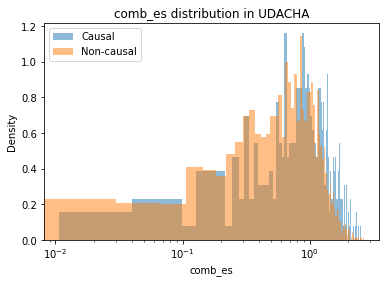

In [44]:
plt.hist(subset.query("label == True")[field], density=True, bins=100, label="Causal", alpha=0.5)
plt.hist(subset.query("label == False")[field], density=True, bins=100, label="Non-causal", alpha=0.5)
plt.xlabel(field)
plt.ylabel("Density")
plt.xscale("log")
plt.title(f"{field} distribution in UDACHA")
plt.legend()
plt.show()